<span style="font-family:Bebas Neue; font-size:2em;">Two Machine Learning Approaches In Skin Lesions Classification - Part 2</span> 

In [1]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import hickle as hkl 
import seaborn as sb
import os
import cv2
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

<span style="font-family:Bebas Neue; font-size:2em;">PARTIAL IMAGE ORIENTED APPROACH</span> 

The idea of using other algorithms borns from the csv file included in the HAM10000 dataset that cannot be used by the CNN. According to dermatologists age of the patient and localization of the skin lesions are very important in the diagnosis, for example some kind of skin moles can be malignant in patients older than 50 years old but they are normal in young people.
However those features alone aren't enough for solve the problem, the aspect of the skin lesion is fundamental! So it's necessary previously a work of feature engineering for fusing the most importants pixels of each image to the metadatas.

## Dataset creation

Firtsly I define the class PixelManager:

In [80]:
class PixelManager:
    def __init__(self):
        self.metadata = pd.read_csv('dataset/HAM10000_metadata.csv')
        self.drop_unknown()
        self.undersample_nv()
        self.importances = hkl.load("importances.hkl")
        self.importances_indexes_sorted = sorted(range(self.importances.size), key=lambda k: self.importances[k], reverse=True)
        
    def drop_unknown(self):
        self.metadata = self.metadata[(self.metadata.sex != 'unknown') & 
                         (self.metadata.localization != 'unknown')].dropna().reset_index(drop=True)
        
    def undersample_nv(self):
        nv_to_delete = self.metadata[self.metadata["dx"]=="nv"]["image_id"].sample(4791)
        self.metadata = self.metadata.drop(nv_to_delete.index).reset_index(drop=True)
        
    def get_best_n_pixels(self, n):
        return self.importances_indexes_sorted[0:n]
    
    def get_best_n_pixels_df(self, n):
        top_n_pixels = self.importances_indexes_sorted[0:n]
        pixel_matrix=[]
        for index, row in self.metadata.iterrows():
            img = cv2.imread(f"dataset/{row['dx']}/{row['image_id']}.jpg")
            img_resize = cv2.resize(img,(64,64))
            gray = cv2.cvtColor(img_resize,cv2.COLOR_BGR2GRAY)
            pixel_matrix.append(gray.reshape(gray.size)[top_n_pixels])
        return pd.DataFrame(pixel_matrix, columns=[f"p{i}" for i in range(1,n+1)])
        
    def complete_with_pixels(self,n):
        return pd.concat([self.metadata, self.get_best_n_pixels_df(n)], axis=1)

In the init I load the metadata csv, and I call the drop_unknown method that drops the 254 rows with NaN or unknown values (I decided to simply drop them because they aren't too much) and the undersample_nv method that, as in the first approach, undersample the "nv" class to have 1700 instances.  
  
Furthermore PixelManager has the get_best_n_pixels method that take in input an integer n and gives in output an array with the indexes of the n most important pixels and the get_best_n_pixels_df that returns a DataFrame containing values of the n most important pixels of each image of the HAM10000 dataset.  
Finally the complete_with_pixels method return the union between the best n pixels DataFrame and the metadata DataFrame.

In [3]:
pixel_manager = PixelManager()

Let's look, for example, what are the 100 most important pixels:

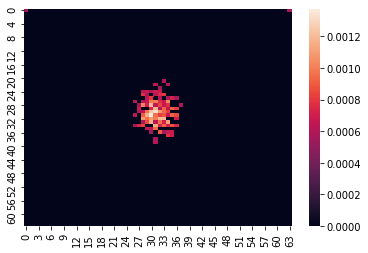

In [4]:
top100_pixel = pixel_manager.get_best_n_pixels(100)
top100_image = [pixel_manager.importances[i] if i in top100_pixel else 0 for i in range(len(pixel_manager.importances))]
sb.heatmap(np.array(top100_image).reshape(64,64))

For this example I'll create the dataset using the 150 best pixels:

In [5]:
metadata_with_pixels = pixel_manager.complete_with_pixels(150)

In [6]:
metadata_with_pixels

,lesion_id,image_id,dx,dx_type,age,sex,localization,p1,p2,p3,...,p141,p142,p143,p144,p145,p146,p147,p148,p149,p150
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,174,179,163,...,203,184,172,109,206,164,194,200,166,135
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,208,175,191,...,169,213,193,141,211,143,171,177,63,162
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,170,177,173,...,168,189,168,142,107,182,158,145,135,156
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,180,171,177,...,164,209,153,134,157,153,179,162,52,192
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,202,194,189,...,160,167,216,164,186,167,93,168,177,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,160,153,172,...,128,194,178,130,88,143,113,118,206,139
4966,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,133,131,135,...,159,170,114,99,153,128,97,164,40,155
4967,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,149,188,145,...,187,214,183,108,141,156,137,156,95,169
4968,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,180,153,171,...,143,177,140,159,169,140,144,152,175,144


Now I get features and target features:

In [7]:
y = metadata_with_pixels["dx"]
X = metadata_with_pixels.drop(['lesion_id','image_id','dx_type','dx'], axis=1, inplace=False)

I One-Hot encode categorical features:

In [8]:
def one_hot_encoder(series): 
    encoder = OneHotEncoder()
    encoder.fit(series)
    return encoder, pd.DataFrame(encoder.transform(series).toarray(), columns=encoder.get_feature_names())

In [9]:
oh_encoder, sex_loc_encoded = one_hot_encoder(X[["sex","localization"]])
X_encoded = pd.concat([sex_loc_encoded, X.drop(["sex","localization"], inplace=False, axis=1)], axis=1)

In [10]:
X_encoded

,x0_female,x0_male,x1_abdomen,x1_acral,x1_back,x1_chest,x1_ear,x1_face,x1_foot,x1_genital,...,p141,p142,p143,p144,p145,p146,p147,p148,p149,p150
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203,184,172,109,206,164,194,200,166,135
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,169,213,193,141,211,143,171,177,63,162
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,168,189,168,142,107,182,158,145,135,156
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,164,209,153,134,157,153,179,162,52,192
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,160,167,216,164,186,167,93,168,177,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,128,194,178,130,88,143,113,118,206,139
4966,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159,170,114,99,153,128,97,164,40,155
4967,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,187,214,183,108,141,156,137,156,95,169
4968,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,143,177,140,159,169,140,144,152,175,144


I smote the dataset for balance it:

In [11]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_encoded, y)

Now I fix the smoted dataset putting 1 at the argmax of each cathegorical feature and 0 at the others.

In [12]:
def indicator(m,n):
    arr=np.zeros(m)
    arr[n]=1
    return arr

In [13]:
smote_sex_df = pd.DataFrame([indicator(2,np.argmax(row)) for row in X_smote[X_smote.columns[0:2]].to_numpy()],
                            columns=X_smote.columns[0:2])
smote_local_df = pd.DataFrame([indicator(14,np.argmax(row)) for row in X_smote[X_smote.columns[2:16]].to_numpy()],
                              columns=X_smote.columns[2:16])
X_norm = pd.concat([smote_sex_df, X_smote.drop(X_smote.columns[0:16], axis=1, inplace=False), smote_local_df], axis=1)

And I normalize pixels and age features.

In [14]:
X_norm[[f"p{i}" for i in range(1,151)]] /= 255
X_norm["age"] /= np.max(X_norm["age"].to_numpy())

In [15]:
X_norm

,x0_female,x0_male,age,p1,p2,p3,p4,p5,p6,p7,...,x1_ear,x1_face,x1_foot,x1_genital,x1_hand,x1_lower extremity,x1_neck,x1_scalp,x1_trunk,x1_upper extremity
0,0.0,1.0,0.941176,0.682353,0.701961,0.639216,0.588235,0.611765,0.615686,0.686275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.941176,0.815686,0.686275,0.749020,0.580392,0.709804,0.643137,0.717647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.941176,0.666667,0.694118,0.678431,0.698039,0.639216,0.670588,0.698039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.941176,0.705882,0.670588,0.694118,0.729412,0.709804,0.725490,0.635294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.882353,0.792157,0.760784,0.741176,0.701961,0.733333,0.733333,0.701961,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11895,1.0,0.0,0.569296,0.329412,0.380392,0.352941,0.372549,0.376471,0.384314,0.384314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11896,1.0,0.0,0.542769,0.533333,0.439216,0.498039,0.482353,0.431373,0.431373,0.435294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11897,1.0,0.0,0.454956,0.419608,0.258824,0.231373,0.219608,0.243137,0.196078,0.231373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11898,1.0,0.0,0.749185,0.435294,0.384314,0.364706,0.352941,0.286275,0.294118,0.372549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Then I build a label encoded version of the dataset that I'll use later for computing features importances.

In [16]:
sex_loc_column = [x for x in smote_sex_df.columns]
for i in smote_local_df.columns:
    sex_loc_column.append(i)
X_le_only = oh_encoder.inverse_transform(X_norm[sex_loc_column])

In [17]:
loc_sex_df = pd.DataFrame(X_le_only, columns=["sex", "localization"])

In [18]:
X_le = pd.concat([loc_sex_df, X_norm.drop([x for x in X_norm.columns if "x" in x], axis=1, inplace=False)], axis=1)

In [19]:
le = LabelEncoder()
X_le["sex"] = le.fit(X_le["sex"]).transform(X_le["sex"])
X_le["localization"] = le.fit(X_le["localization"]).transform(X_le["localization"])

And finally I get training and test sets:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_smote, test_size=0.2)

## Models training

## Random Forest

After tuning number of tree, max depth of each tree and max features used for splitting, I obtained the following model:

In [45]:
rf = RandomForestClassifier(n_estimators=240, n_jobs=-1, max_depth=70, max_features=40, criterion="entropy")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       akiec       0.88      0.95      0.91       333
         bcc       0.88      0.94      0.91       338
         bkl       0.74      0.70      0.72       328
          df       0.92      1.00      0.96       301
         mel       0.75      0.67      0.71       375
          nv       0.77      0.72      0.74       362
        vasc       0.96      0.99      0.97       343

    accuracy                           0.85      2380
   macro avg       0.84      0.85      0.85      2380
weighted avg       0.84      0.85      0.84      2380



## Tree-based AdaBoost

After tuning number of estimators and max depth of each tree, I obtained the following model:

In [47]:
weak_classifier = tree.DecisionTreeClassifier(max_depth=15)
ada = AdaBoostClassifier(algorithm='SAMME', base_estimator=weak_classifier, random_state=1, n_estimators=150)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       akiec       0.91      0.96      0.93       333
         bcc       0.89      0.96      0.92       338
         bkl       0.75      0.75      0.75       328
          df       0.96      1.00      0.98       301
         mel       0.78      0.67      0.72       375
          nv       0.74      0.72      0.73       362
        vasc       0.99      0.98      0.98       343

    accuracy                           0.86      2380
   macro avg       0.86      0.86      0.86      2380
weighted avg       0.85      0.86      0.85      2380



## Support Vector Machine

After tuning class weights and choose the best kernel, I obtained the following model:

In [49]:
class_weights = {'akiec': 100,'bcc': 100,'bkl': 250.0,'df': 100,'mel': 250.0,'nv': 250.0,'vasc': 100}
svc = SVC(class_weight=class_weights)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       akiec       0.92      0.98      0.94       333
         bcc       0.87      0.97      0.92       338
         bkl       0.72      0.81      0.76       328
          df       0.96      1.00      0.98       301
         mel       0.79      0.69      0.74       375
          nv       0.84      0.65      0.73       362
        vasc       0.97      1.00      0.98       343

    accuracy                           0.86      2380
   macro avg       0.86      0.87      0.86      2380
weighted avg       0.86      0.86      0.86      2380



## K-Fold cross validation

Finally I do a Kfold cross validation for each model and I compare the results:

In [60]:
kf = KFold(n_splits=4, shuffle=True)
kfold_accuracies = dict()
iteration = 0
for model in [rf, ada, svc]:
    iteration = 0
    model_name = str(model).split("(")[0]
    kfold_accuracies[model_name] = list()
    for train_index, test_index in kf.split(X_norm.to_numpy()):
        iteration += 1
        print(f"Starting KFold {iteration} for {model_name}")
        model.fit(X_norm.to_numpy()[train_index], y_smote.to_numpy()[train_index])
        accuracy = accuracy_score(model.predict(X_norm.to_numpy()[test_index]),y_smote.to_numpy()[test_index])
        kfold_accuracies[model_name].append(accuracy)

Starting KFold 1 for RandomForestClassifier
Starting KFold 2 for RandomForestClassifier
Starting KFold 3 for RandomForestClassifier
Starting KFold 4 for RandomForestClassifier
Starting KFold 1 for AdaBoostClassifier
Starting KFold 2 for AdaBoostClassifier
Starting KFold 3 for AdaBoostClassifier
Starting KFold 4 for AdaBoostClassifier
Starting KFold 1 for SVC
Starting KFold 2 for SVC
Starting KFold 3 for SVC
Starting KFold 4 for SVC


Let's look at the results computing the mean of each model's accuracy in the four KFold splits:

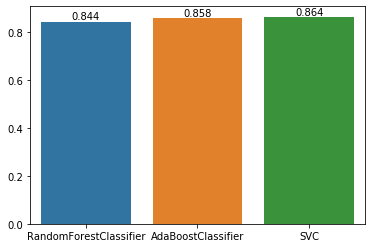

In [82]:
splot = sb.barplot(y=[np.mean(kfold_accuracies[model]) for model in kfold_accuracies.keys()], x=list(kfold_accuracies.keys()))
for p in splot.patches:
    splot.annotate(format(p.get_height(),'.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0,5), textcoords='offset points')

Remembering CNN KFold accuracy was 0.842, Random Forest model have similar accuracy but AdaBoost and mostly Support Vector Machines overperform the full image oriented approach. 

## Features importance

I conclude the analysis looking at the features importance computed training the tuned Random Forest with the label encoded dataset defined previously:

Text(0, 0.5, 'Features')

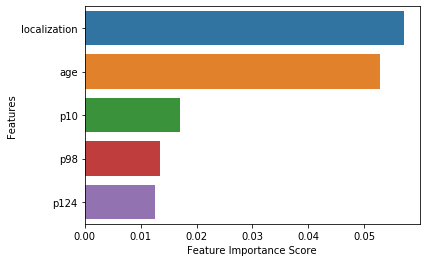

In [84]:
importance_tree = RandomForestClassifier(n_estimators=440, n_jobs=-1, max_depth=70, max_features=40)
importance_tree.fit(X_le, y_smote)
feature_imp = pd.Series(importance_tree.feature_importances_, index=X_le.columns).sort_values(ascending=False)
imp=pd.DataFrame(feature_imp)
sb.barplot(x=feature_imp[:5], y=feature_imp.index[:5])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

As I expected, "localization" and "age" are incredibly heavy in the classification task.  
So, doing a more careful feature engineering made non deep methods (with also a great dimensionality reduction since these algorithms were trained on 167 features instead of 64*64 = 4096) overperform CNN in a image classification task!